# Landing Rating System



## Imports libraries

In [1]:
import os

# Dataframe and Mathematical Toolbox
import pandas as pd
import numpy as np
import datetime as dt
from scipy.signal import find_peaks
# Visualization Packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

import seaborn as sns

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', 100)

## Tacview csv flight data

In [34]:
# Tacview Data Parameters
sampling_rate = 10 # Hz

input_path= r"C:\Users\Fardad\Desktop\Landing Rating\Datasets\Tacview-20250826-201519-DCS-Host-F-16 IQT Session 11.csv"
results_dir = r'..\Landing Rating\Results\2025.08.26 Live'
os.makedirs(results_dir, exist_ok=True)

# Read csv file
df = pd.read_csv(input_path)

# Get date from tacview file
date_tacview = pd.to_datetime(df.loc[0,'ISO time'], errors='coerce').strftime('%Y-%m-%d')

df.head(2)

,ISO time,Unix time,Id,Longitude,Latitude,Altitude,Roll,Pitch,Yaw,U,V,Heading,Name,Pilot,CAS,AGL,VS
0,2020-06-01T01:15...,1.590974e+09,102,55.291167,24.696392,10664.24,0.0,0.2,220.5,-97119.98,-162525.33,221.2,E-3A,Aerial-6-1,NaN,10557.570801,NaN
1,2020-06-01T01:15...,1.590974e+09,202,56.189998,25.645405,7616.24,0.0,0.2,271.8,-5550.65,-58268.62,272.2,KC-135,Aerial-9-1,NaN,7023.751221,NaN


## Filter to Pilots List

In [36]:
# # Choose Pilots to be evaluated

Freelancers_Pilots = ['< 404C > Dragon 5',   '< 404C > F.U.B.A.R', '< 404C > IR.shadow', '< 404C > Ghost', '< 404C > Mustang',
                      '< 404C > Phoenix' ,   '< 404C > Sensei'   ] + \
                     ['< 404C > Arsenlopen', '< 404C > LCDR vici'] + \
                     ['< 404 > ALPHA-WHISKEY', '< 404 > Aria', '< 404 > A D L E R',
                      '< 404 > D1CE', '< 404 > FanBoy', '< 404 > Hawk_7', 'HoneyBadger']

observed_Pilots = sorted(Freelancers_Pilots)
print(observed_Pilots)

# Filter df to observed_Pilots
df = df[df['Pilot'].isin(observed_Pilots)]

['< 404 > A D L E R', '< 404 > ALPHA-WHISKEY', '< 404 > Aria', '< 404 > D1CE', '< 404 > FanBoy', '< 404 > Hawk_7', '< 404C > Arsenlopen', '< 404C > Dragon 5', '< 404C > F.U.B.A.R', '< 404C > Ghost', '< 404C > IR.shadow', '< 404C > LCDR vici', '< 404C > Mustang', '< 404C > Phoenix', '< 404C > Sensei', 'HoneyBadger']


## `df_sub`: Unit Conversion & Clean-ups

- Subset df to `Pilot` + `CAS` + `AGL` + `VS` + `long` + `lat`
- Time Wrangling: Extracting timestamp minutes, seconds from `ISO time` column

In [37]:
df_sub = df[['ISO time', 'Name', 'Pilot', 'Longitude','Latitude', 'CAS', 'AGL', 'VS']]

# Unit Conversion
df_sub.loc[:, 'CAS'] = df_sub['CAS'] * 2      # convert CAS from unknown to kts
df_sub.loc[:, 'VS' ] = df_sub['VS' ] * 196.85  # convert VS from m/s to ft/min
df_sub.loc[:, 'AGL'] = df_sub['AGL'] * 3.28084 # convert AGL from m to ft

# Clean-up from NaN values for `VS`
df_sub = df_sub.dropna(axis=0, subset=['VS']) .reset_index(drop=True)

###################################

# ISO time to datetime object
df_sub.insert(  0, 'timestamp', pd.to_datetime(df_sub['ISO time']).dt.time )

# Convert to seconds
df_sub.insert(  1, 'timestamp_seconds', df_sub['timestamp'].apply(lambda x: pd.to_timedelta(str(x)).total_seconds()) )

#drop the 'ISO time'
df_sub.drop(columns=['ISO time'], inplace=True)

df_sub.head(3)

,timestamp,timestamp_seconds,Name,Pilot,Longitude,Latitude,CAS,AGL,VS
0,01:30:26.399117,5426.399117,F-16C_50,< 404C > Ghost,55.614617,24.25659,0.0,6.200786,-3.568387
1,01:30:26.499117,5426.499117,F-16C_50,< 404C > Ghost,55.614617,24.25659,0.0,6.200786,-2.631235
2,01:30:26.599116,5426.599116,F-16C_50,< 404C > Ghost,55.614617,24.25659,0.0,6.200786,-1.967419


# Approach & Impact Analysis

## Vertical Speed, Acceleration, Jerk
- Right discrete derivative ${\frac{d^+}{dt}}VS \approx (VS_{t+1}-VS_{t-1})/2$
- Right discrete Jerk       ${\frac{d^{+2}}{dt^2}}VS \approx (VS'_{t+1}-VS'_{t-1})/2$
- <s> pct_chg of VS_chg_rate </s>

In [39]:
def pct_chg_abs(x1, x2):
    return ((x2 - x1) / abs(x1)) * 100

# Time, AGL, VS increments
time_diff = df_sub.groupby('Pilot')['timestamp_seconds'].transform(lambda x: x.shift(-1) - x.shift(1))
VS_diff   = df_sub.groupby('Pilot')['VS']               .transform(lambda x: x.shift(-1) - x.shift(1))

# Vertical Acceleration (fpm2)
df_sub['vert_Acc_fpm2'] = (VS_diff / time_diff) * 60

# Vertical Acc increments
vert_Acc_diff = df_sub.groupby('Pilot')['vert_Acc_fpm2'].transform(lambda x: x.shift(-1) - x.shift(1)) 
                                                                
# Vertical Jerk
df_sub['vert_Jerk_fpm3'] = (vert_Acc_diff / time_diff) * 60

## Impact Discovery

In [ ]:
agl_threshold = 8  # feet
vs_threshold = -30  # feet per minute
aircraft_CG_height = {'F-16C_50': 6, 'F-15C': 6.5}
aircraft_stall_speed = {'F-16C_50': 110, 'F-15C': 110, 'FA-18C_hornet': 110}

# ------ CONDITIONS for TOUCHDOWN  for Each Pilot ------
grouped_by_pilot = df_sub.groupby('Pilot')

# Condition 1: AGL is a local minimum (current AGL is less than previous AND next)
is_decreasing_agl = (df_sub['AGL'] < grouped_by_pilot['AGL'].transform('shift', +1)) & \
                    (df_sub['AGL'] < agl_threshold) & \
                    (df_sub['AGL'] - grouped_by_pilot['AGL'].rolling(window=50, center=True, min_periods=1).min().reset_index(level=0, drop=True) < 3)  &\
                    (grouped_by_pilot['AGL'].rolling(window=50, min_periods=1).max().reset_index(level=0, drop=True) > 10)
                    # (df_sub['AGL'] < grouped_by_pilot['AGL'].transform('shift', +1)) & \  

# Condition 2: VS is below the threshold
is_low_vs = (df_sub['VS'] < vs_threshold) & (df_sub['VS'] > -2000) # Sanity Check

# Condition 3: CAS is above stall speed
is_above_stall = df_sub['CAS'] > df_sub['Name'].map(aircraft_stall_speed)

# Condition 4: Jerk is decreasing (current jerk is greater than next jerk)
is_local_max_jerk = (df_sub['vert_Jerk_fpm3'] == (grouped_by_pilot['vert_Jerk_fpm3'].rolling(window=1, center= True, min_periods=1).max().\
                                                                                     reset_index(level=0, drop=True)).sort_index() )     & \
                    (df_sub['vert_Jerk_fpm3'] > 10000)                                                                    

# Condition 5: Vertical Acceleration becomes positive "in short time"
is_positive_acc = grouped_by_pilot['vert_Acc_fpm2'].rolling(window=int(0.5*sampling_rate), center= False, min_periods=1).max().iloc[::-1].\
                                                    reset_index(level=0, drop=True).sort_index() > 0


# ------ TOUCHDOWN Candidates ------

# Combine all conditions into a single boolean mask
all_conditions_met = is_decreasing_agl & is_low_vs & is_above_stall & is_local_max_jerk & is_positive_acc
df_td_candidates = df_sub[all_conditions_met].copy()

# A "TRUE TOUCHDOWN" is a candidate where the time since the last one is > 5 seconds,
# or it's the very first one for that pilot (where time_since_last_td is NaN)
df_td_candidates['time_since_last_td'] = df_td_candidates.groupby('Pilot')['timestamp_seconds'].diff()

is_true_touchdown = (df_td_candidates['time_since_last_td'] > 5) | (df_td_candidates['time_since_last_td'].isna())
true_touchdown_indices = df_td_candidates[is_true_touchdown].index

# df_td_candidates[is_true_touchdown]

# --- Impact Analysis Result Back to df_sub ---
df_sub['is_touchdown'] = False
df_sub.loc[true_touchdown_indices, 'is_touchdown'] = True


###### Result Summary df_result ########

# Filter to touchdowns
df_result = df_sub[df_sub['is_touchdown']].drop(columns=[ 'is_touchdown']). \
                                              reset_index(drop=True)

# Rename col to td_col
df_result = df_result.rename(columns={ 'timestamp': 'td_timestamp',
                                       'timestamp_seconds': 'td_timestamp_seconds',
                                       'Longitude': 'td_longitude',
                                       'Latitude': 'td_latitude',
                                       'CAS': 'CAS_kt', 'AGL': 'AGL_ft', 'VS': 'VS_fpm'})

# Count sortie number
df_result.insert(0, 'sortie_num', df_result.groupby('Pilot').cumcount() + 1)

## Final Approach Profile Analysis

- All data 60s prior to touchdown to 1s after that: `df_final_approach`

In [44]:
def haversine (lat1,lon1,lat2,lon2):
    '''Calculates the 2D distance between two lat/lon coordinates (lat1,lon1) and (lat2,lon2).'''
    R = 6371  # Radius of the Earth in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) ** 2
    dist = 2 * R * np.arcsin(np.sqrt(a)) * 3280.84  # convert to ft
    return dist

In [ ]:
# Which part of final approach are we interested in?
final_segment = 60

# --- Associate Every Data Point with its Upcoming Landing ---

# We merge only the rows where the upcoming
# touchdown is within 20 seconds.
df_forward = pd.merge_asof(
    left=df_sub,
    right=df_result[['sortie_num', 'Pilot', 'td_timestamp', 'td_timestamp_seconds', 'td_longitude', 'td_latitude']],
    left_on='timestamp_seconds',
    right_on='td_timestamp_seconds',
    by='Pilot',
    direction='forward',        # Look for the next touchdown
    tolerance= final_segment    # Only match if the touchdown is <= 60 seconds away
)

df_backward = pd.merge_asof(
    left=df_sub,
    right=df_result[['sortie_num', 'Pilot', 'td_timestamp', 'td_timestamp_seconds', 'td_longitude', 'td_latitude']],
    left_on='timestamp_seconds',
    right_on='td_timestamp_seconds',
    by='Pilot',
    direction='backward',  # Look for the next touchdown
    tolerance=5,          # Only match if the touchdown is <= 20 seconds away
    allow_exact_matches = False # Touchdown entry itself is already included in df_forward
)

# Only keeping entries upto 20s prior to touchdown
df_forward.dropna(subset=['td_latitude'], inplace=True)
df_backward.dropna(subset=['td_latitude'], inplace=True)

# sortie_number in df_backward is actually the sortie number of the flight prior to touchdown
df_backward.rename(columns={'sortie_num': 'sortie_extended'}, inplace=True)

# Calculate Distance to Touchdown
df_forward['distance_to_touchdown']  = df_forward.apply (lambda row:   haversine(row['Latitude'], 
                                                                                 row['Longitude'], 
                                                                                 row['td_latitude'],
                                                                                 row['td_longitude']
                                                                                )                     ,axis=1)
# Distance To Touchdown after touchdown in negative direction
df_backward['distance_to_touchdown'] = df_backward.apply(lambda row: - haversine(row['Latitude'], 
                                                                                 row['Longitude'], 
                                                                                 row['td_latitude'],
                                                                                 row['td_longitude']
                                                                                )                     ,axis=1)

df_forward['sortie_num'] = df_forward['sortie_num'].astype(int)
df_backward['sortie_extended'] = df_backward['sortie_extended'].astype(int)

# New df containing data 20s prior to touchdowns to 1 second after
df_final_approach = pd.concat([df_forward, df_backward], axis=0)
df_final_approach.sort_values(by=['timestamp_seconds'], inplace=True)

# index = (df_final_approach['timestamp'].astype(str) > '02:01:19.79') & (df_final_approach['timestamp'].astype(str) < '02:01:19.84')
# df_final_approach.loc[ index ]


# Results

## Touchdown Ratings

In [ ]:
# Stylizing the Touchdowns Table
display_formatter = {'vert_Jerk_fpm3': '{:.2e}'}
for col in df_result.columns[df_result.columns.get_loc('CAS_kt'):df_result.columns.get_loc('vert_Acc_fpm2')+1]:
    display_formatter[col] = '{:.2f}'

# Export to csv
df_result.drop(columns=['td_timestamp_seconds']).to_csv  (os.path.join(results_dir, 'landing_analysis_results.csv'), index=False)
df_result.drop(columns=['td_timestamp_seconds']).to_html (os.path.join(results_dir, 'landing_analysis_results.html'), index=False)

# Display Results Table
df_result.drop(columns=['td_timestamp_seconds']).style.format(display_formatter)

# Visualizations

### Final Approach Profile

- *thresholds* $= \big( -\infty, x_{min} , \cdots, x_{max}, +\infty \big).$
- $(\text{strictness factor})*(\frac{x^k - x_{min}^k}{x_{max}^k - x_{min}^k})$ maps *thresholds* into $[0,1]$.

In [94]:
import re

def extract_pilot_name(pilot):
    """Extracts the pilot's name, removing the leading '< 404 > ' or '< 404C > ' if present."""
    match = re.match(r"<\s*404[C]?\s*> (.*)", pilot)
    if match:
        return match.group(1)
    return pilot  # Return original name if no match


<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Fardad\AppData\Local\Temp\ipykernel_3340\3550212631.py:12: SyntaxWarning: invalid escape sequence '\l'
  labels = [f'$\leq$ {thresholds[1]}']
C:\Users\Fardad\AppData\Local\Temp\ipykernel_3340\3550212631.py:14: SyntaxWarning: invalid escape sequence '\g'
  labels.append(  f'$\geq 0$'  )


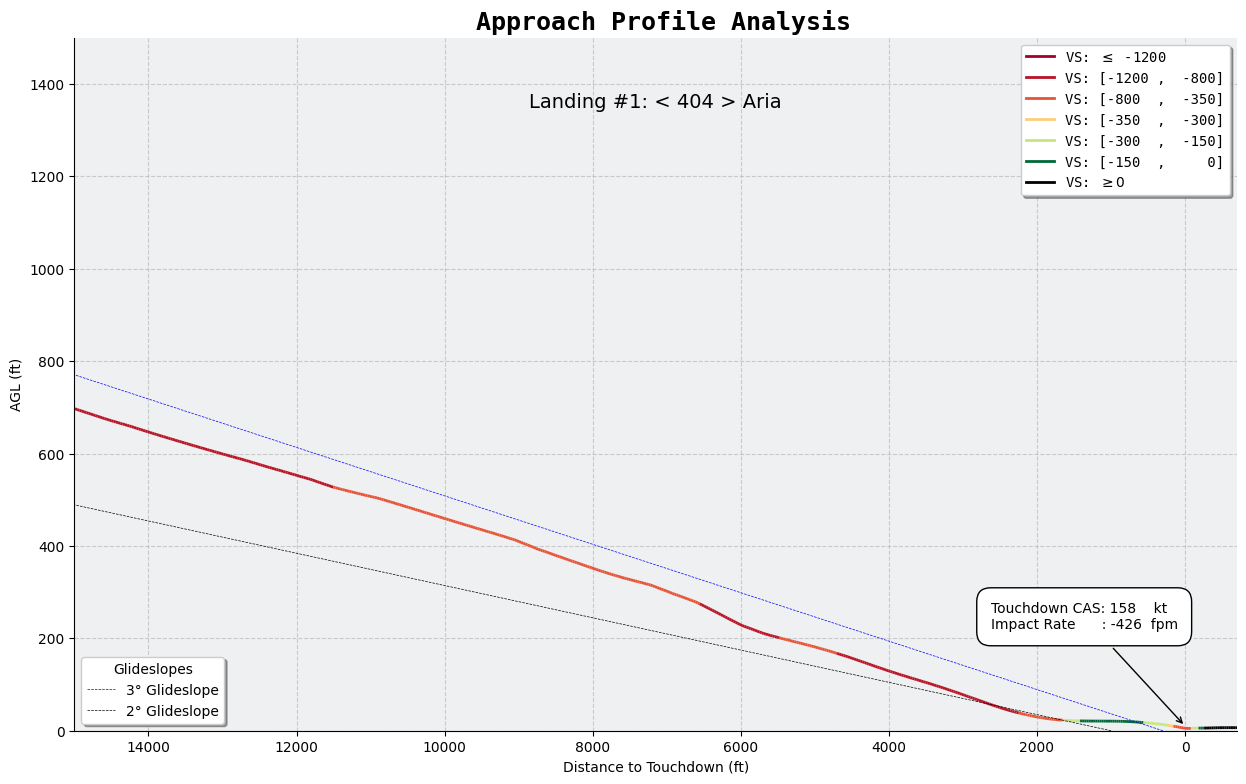

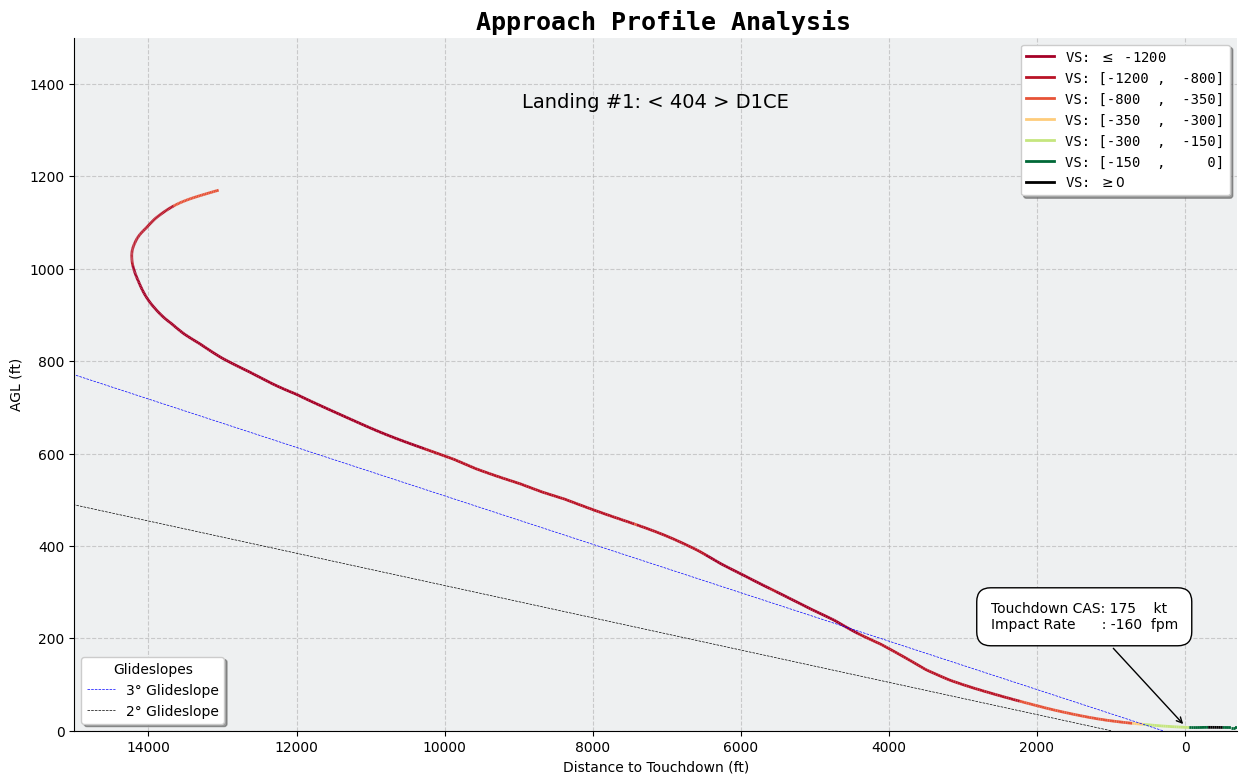

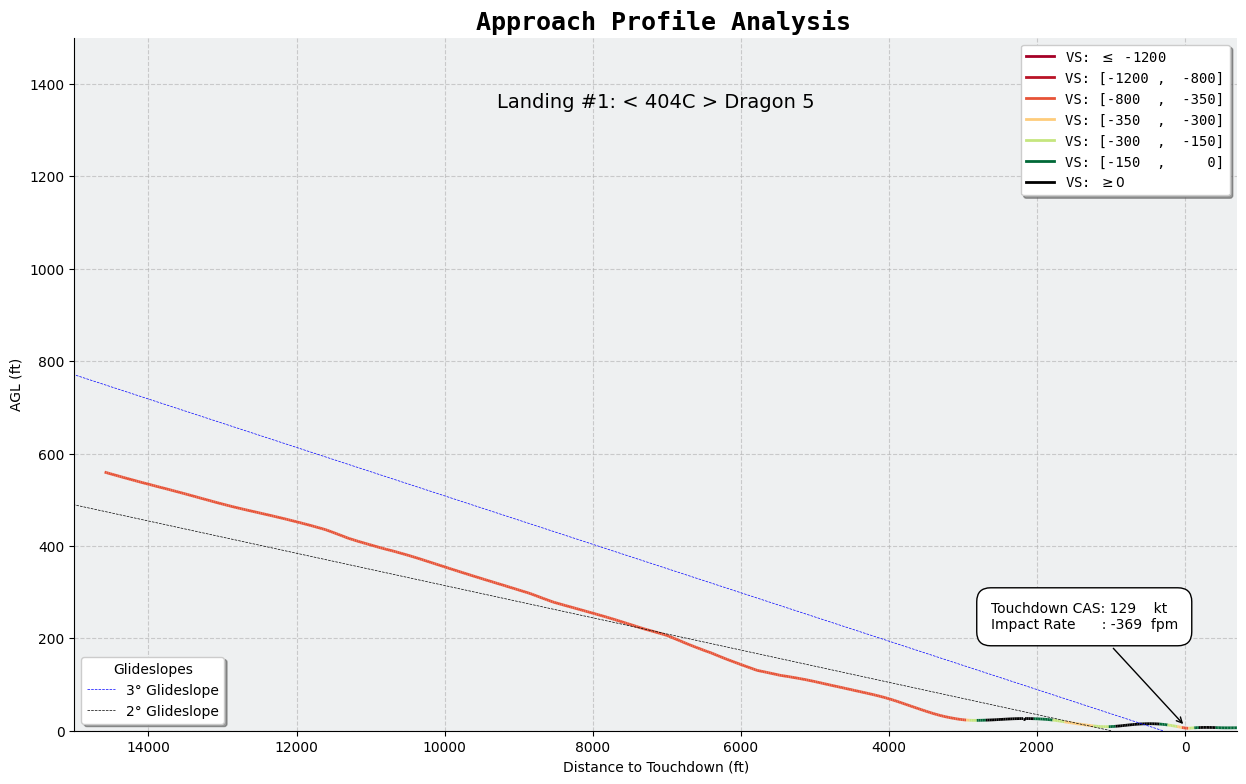

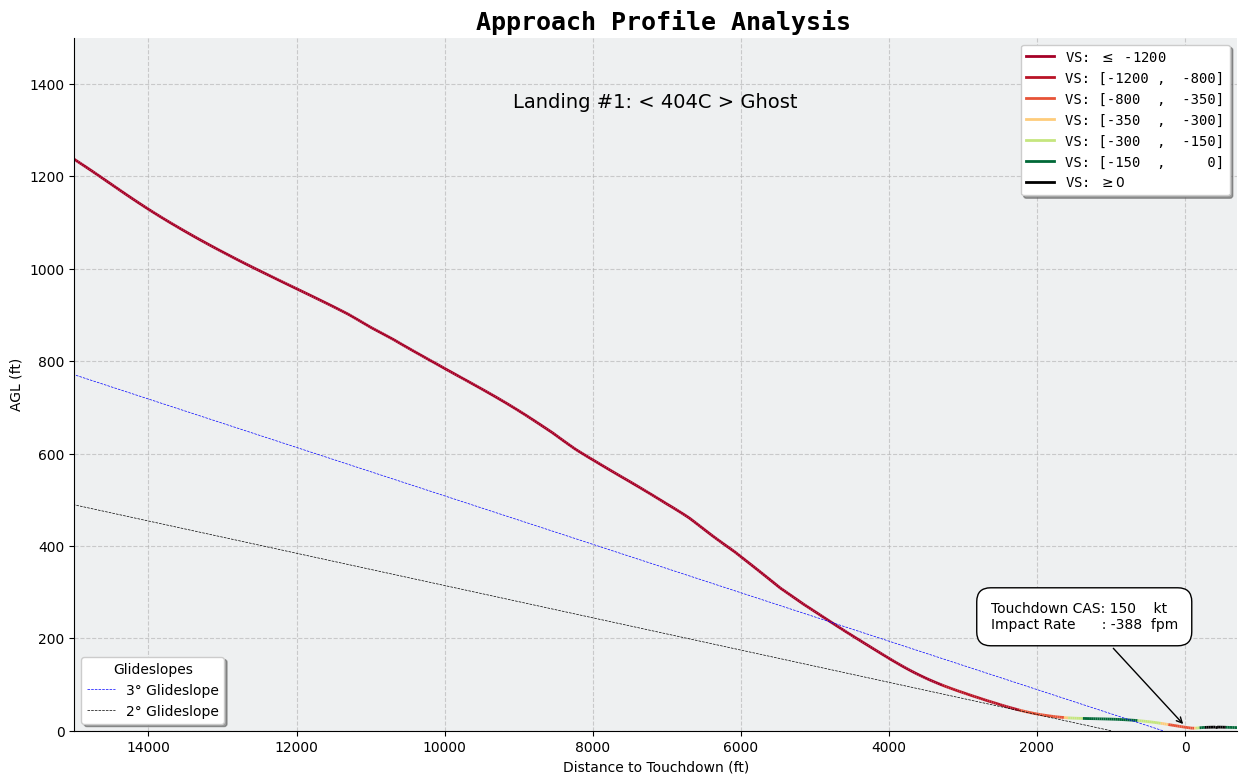

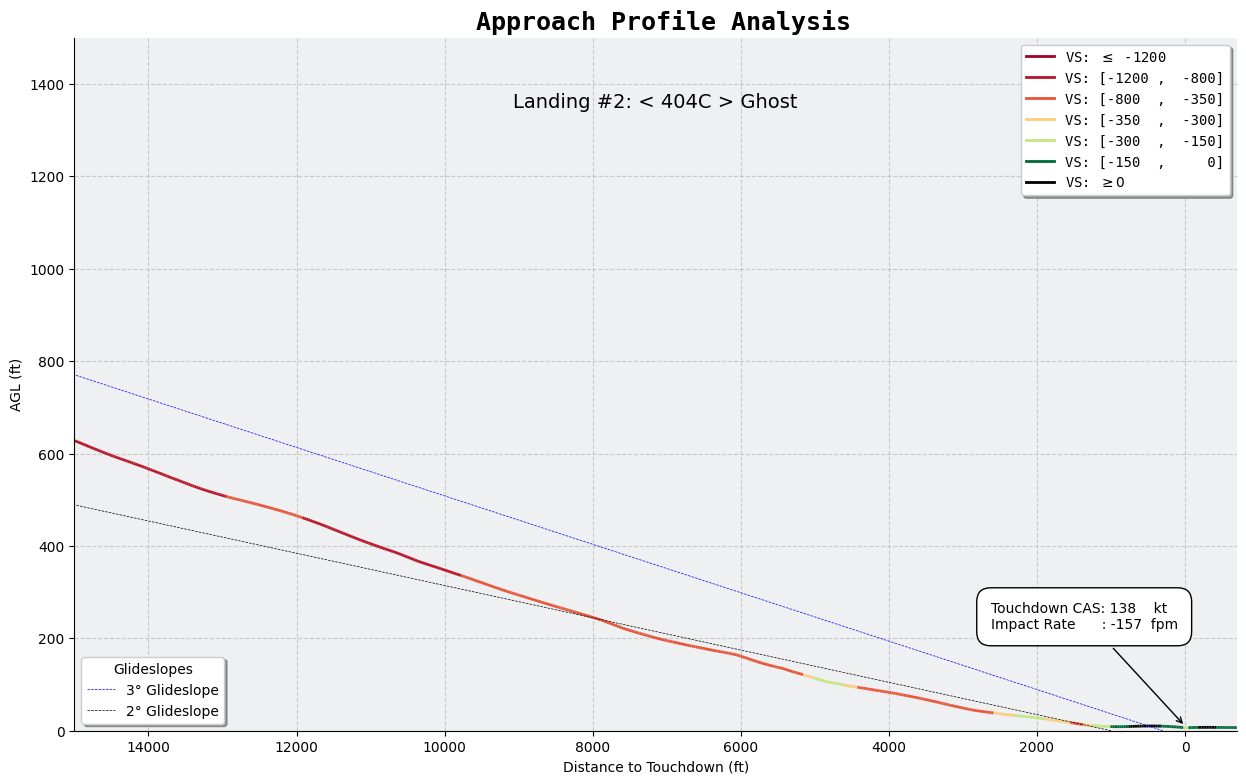

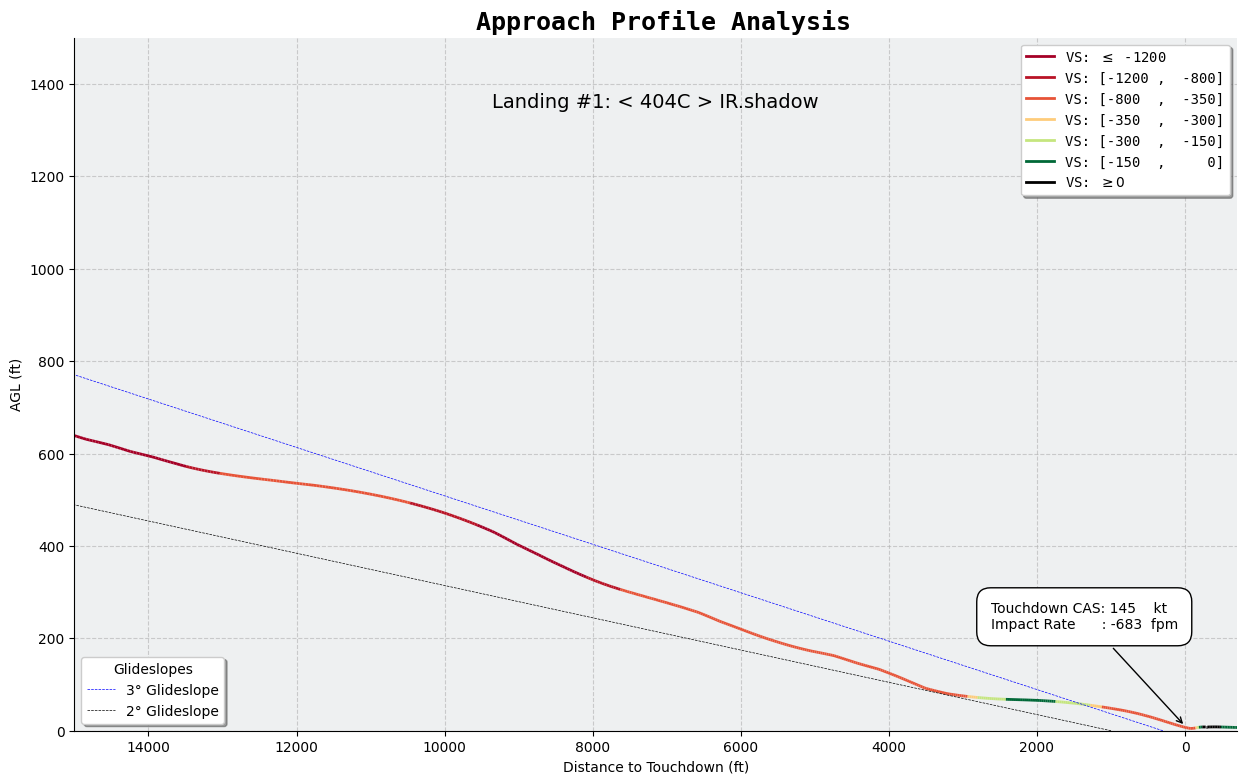

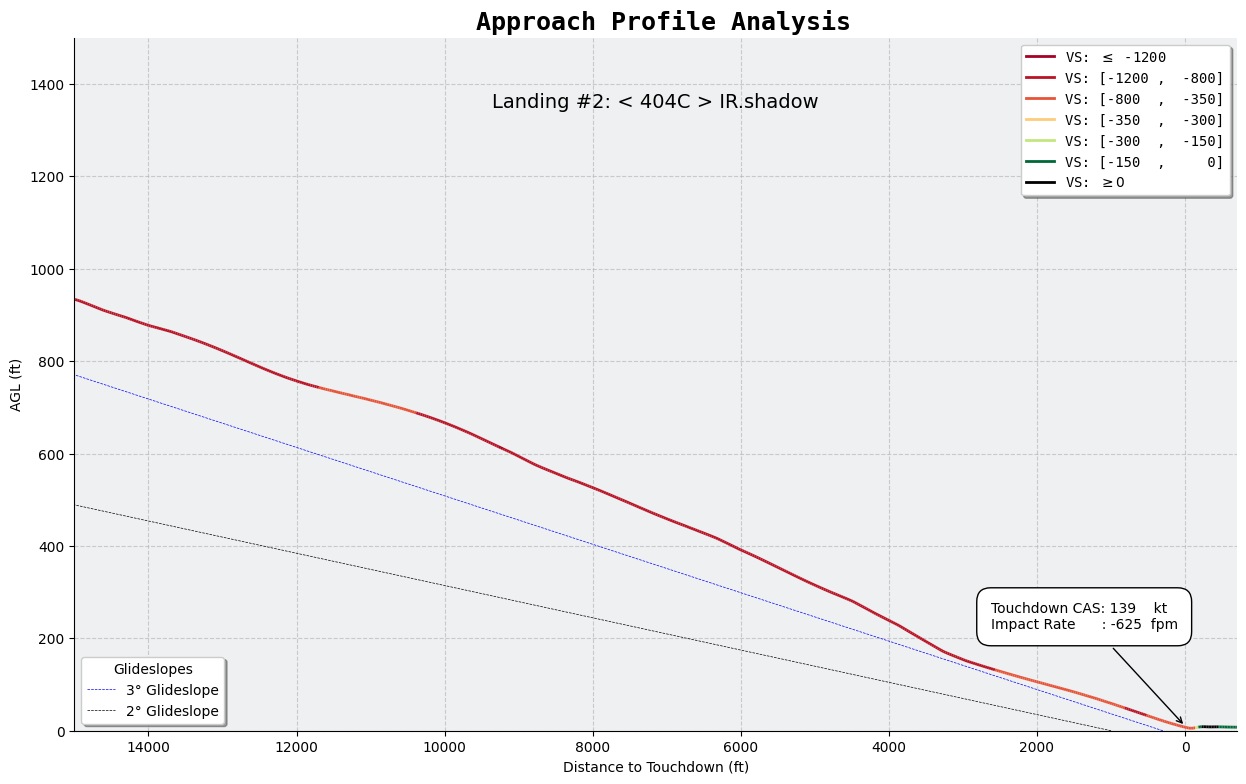

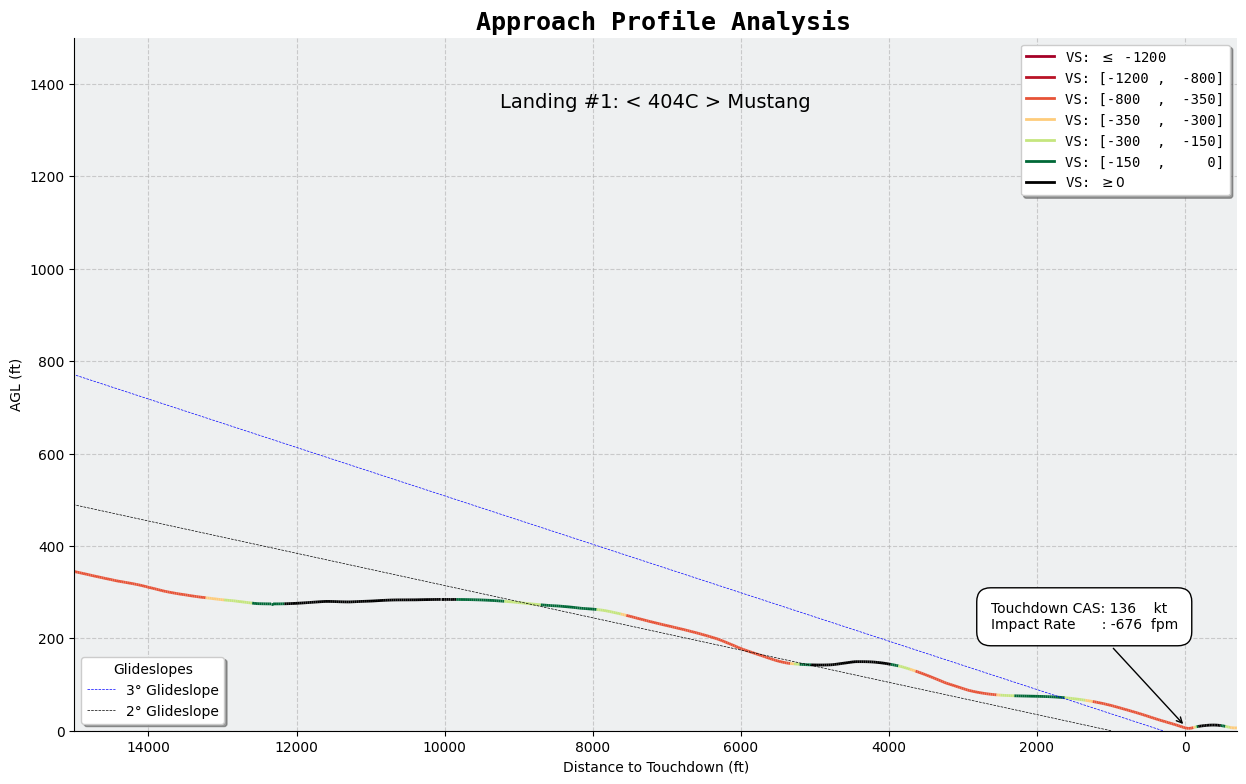

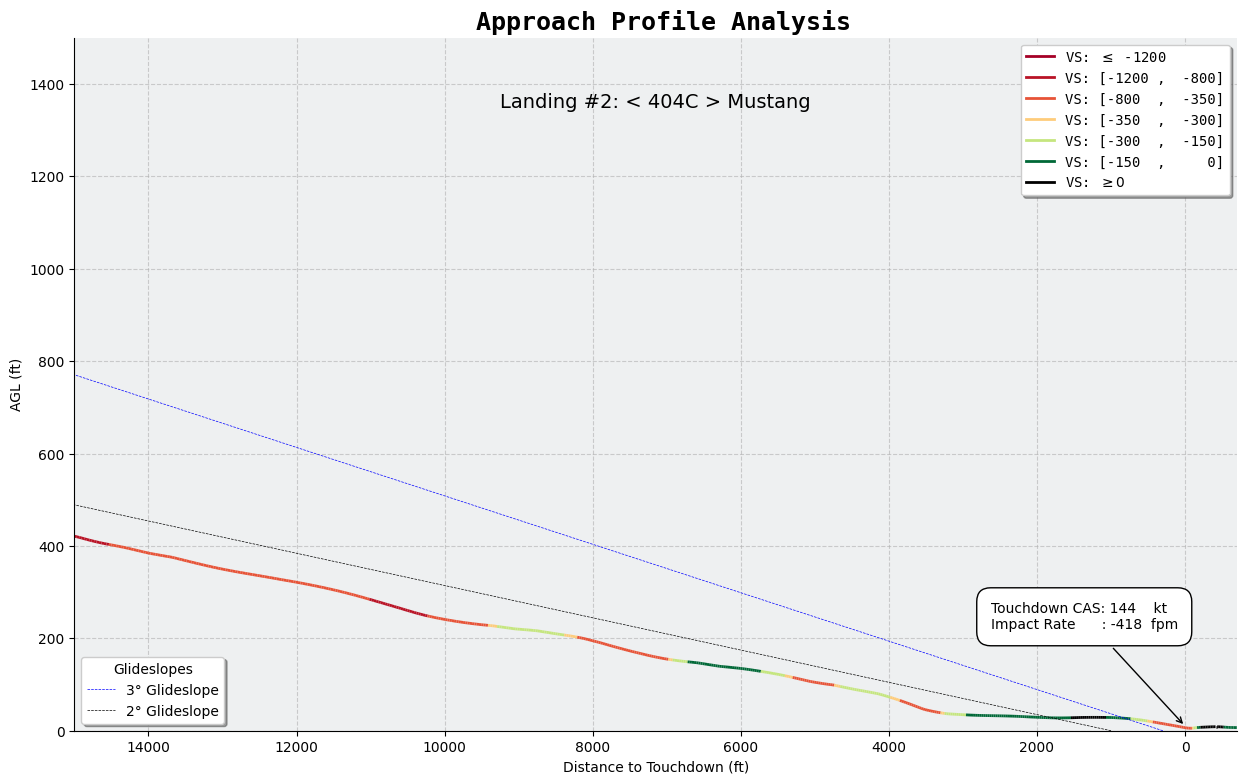

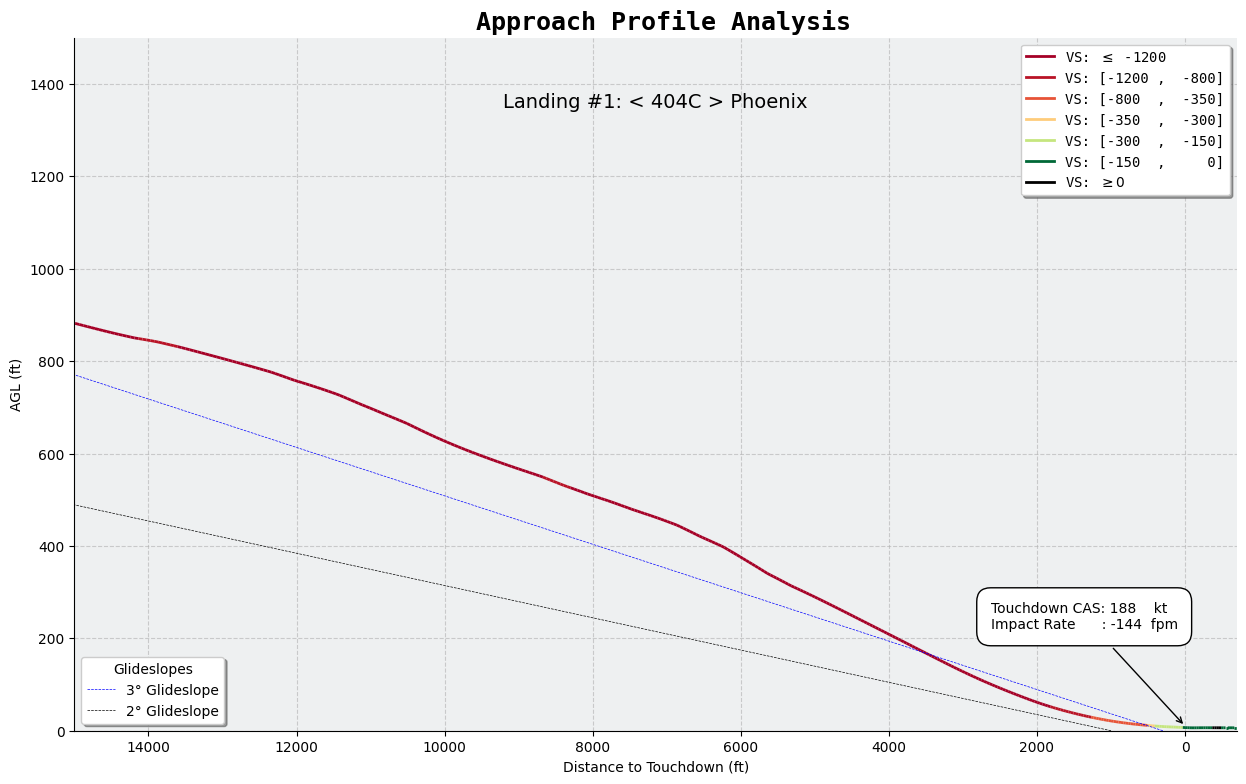

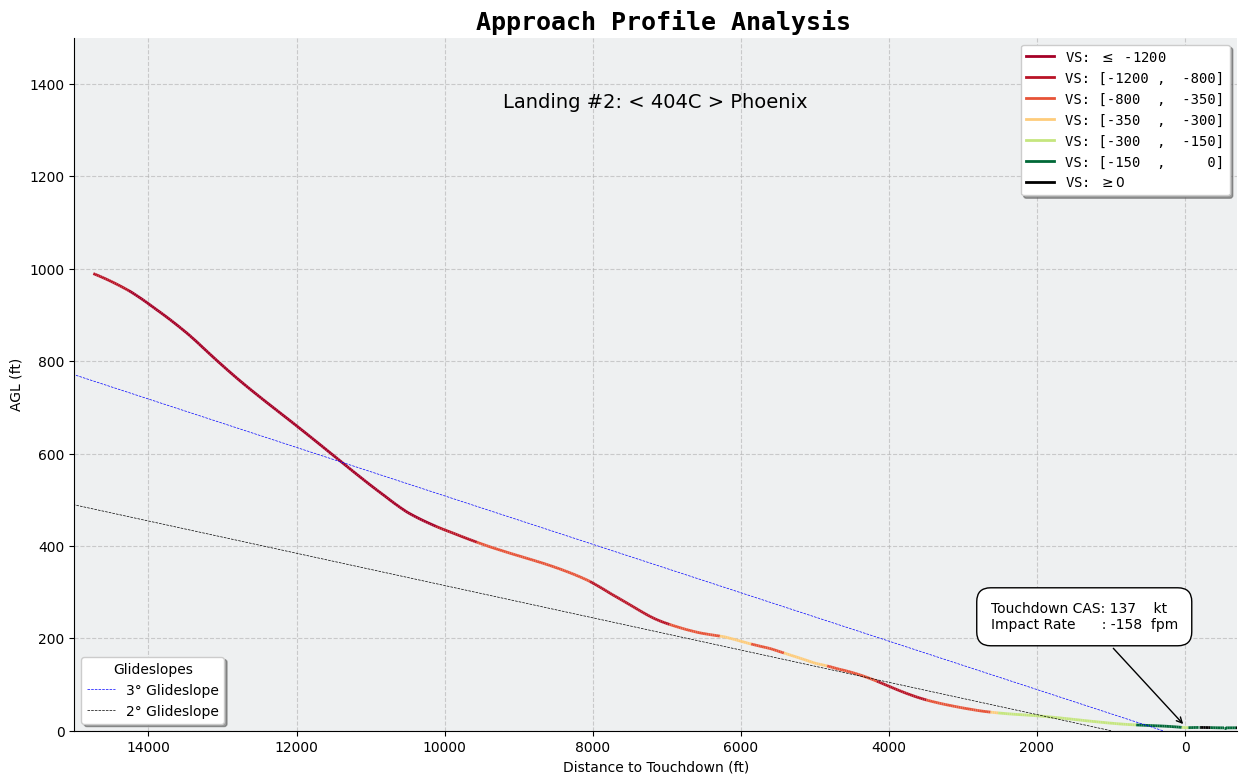

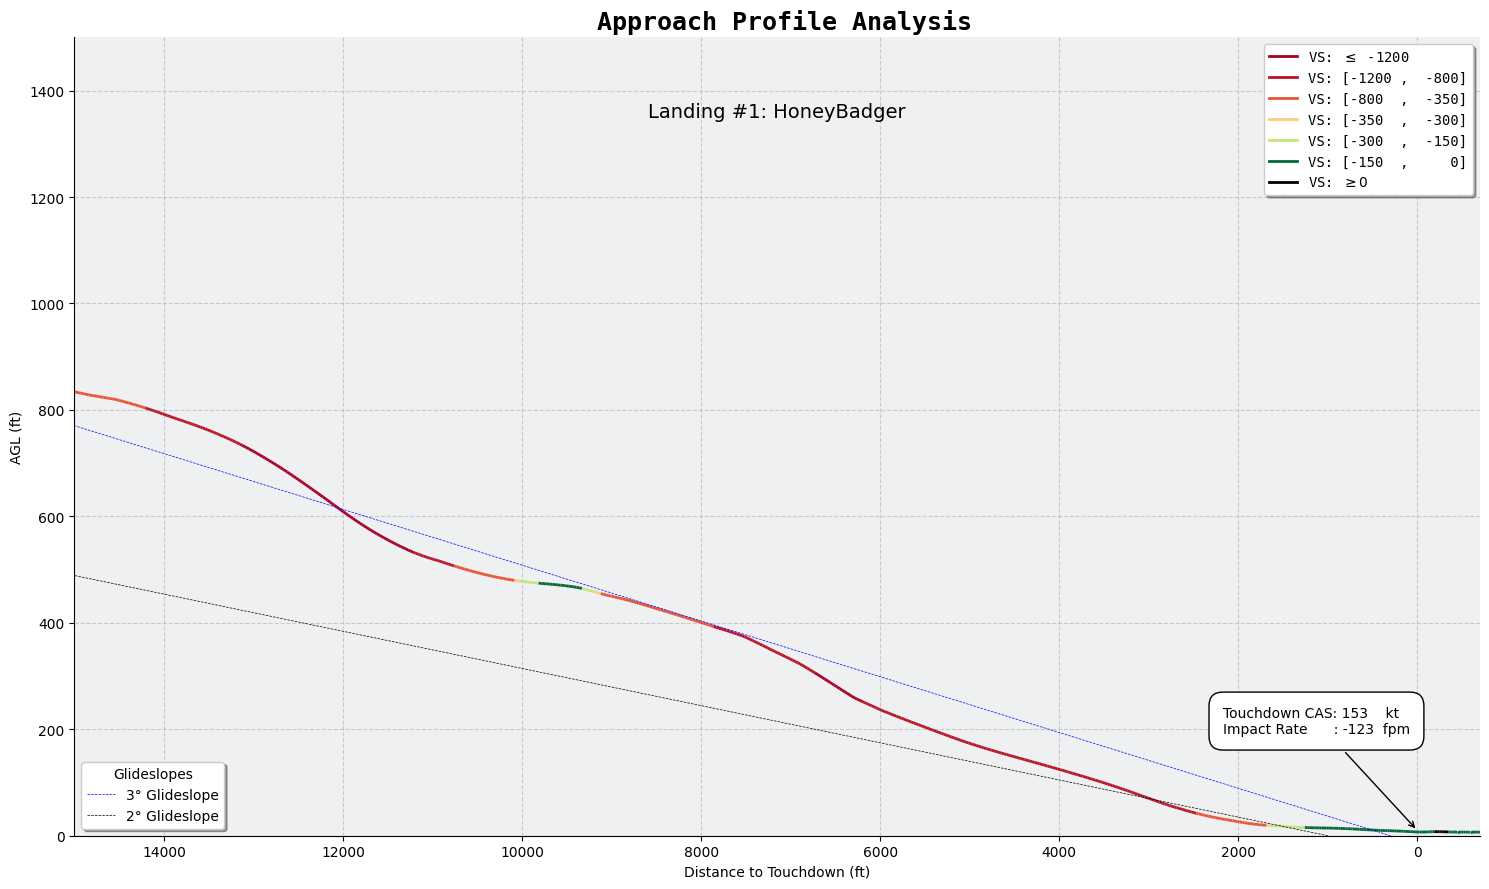

In [96]:
# ############## Thresholds and Colormaps ##############
# Select a colormap
cmap = plt.get_cmap('RdYlGn') 

# Create 'descent_rate' column
thresholds = [-np.inf, -1200, -800, -350, -300, -150, 0, np.inf]
min_thrshld = abs(sorted(thresholds)[1])   # worst threshold = 1200
max_thrshld = abs(sorted(thresholds)[-2])  # best  threshold = 150
# thresholds = np.sort(thresholds)[::-1]  # Sort in descending order
num_categories = len(thresholds) - 1

labels = [f'$\leq$ {thresholds[1]}']
labels = labels + [f'[{thresholds[i]:<5g} , {thresholds[i+1]:5g}]' for i in range(1,len(thresholds)-2)]
labels.append(  f'$\geq 0$'  )

colors_list = [mcolors.to_hex(cmap( i**2 )) for i in np.linspace(0, 1, num_categories-1)]
colors_list.append(  '#000000'  )

color_map = dict(zip(labels, colors_list))
# color_map[np.nan] = "#000000" # replace NaN (for >=0 or too steep VS) with black

df_final_approach['descent_quality'] = pd.cut(  df_final_approach['VS'],
                                                bins=thresholds,
                                                labels=labels,
                                                include_lowest=True)  # include_lowest is important for the bottom boundary



# ############## Approach Plotter Function ##############
def approach_plotter(pilot, number_sortie):

    plt.style.use('default')

    # Filter for the current pilot and sortie number
    overall_sortie_num = df_result[(df_result['Pilot'] == pilot)]['sortie_num'].max() # overal num of landings of this pilot
    df_plot = df_final_approach[   (df_final_approach['Pilot'] == pilot) & \
                                   ((df_final_approach['sortie_num'] == number_sortie) + (df_final_approach['sortie_extended'] == number_sortie))   ]

    # Ensure the DataFrame is not empty
    if df_plot.empty:
        print(f"No data available for {pilot}")
        return
    
    # Map colors to descent_qualities
    colors = df_plot['descent_quality'].map(color_map, na_action=None)

    # Create segments for the LineCollection
    points = np.array([df_plot['distance_to_touchdown'], df_plot['AGL']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection object
    # The colors are applied to each segment
    lc = LineCollection(segments, colors=colors[:-1], linewidths=2)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(15, 9))
    
    ax.add_collection(lc)
    ax.autoscale_view()

    # Graphics
    ax.grid(True, linestyle='--', alpha=0.6) # Added gridlines, adjusted alpha
    ax.set_facecolor("#EEF0F1FF")

    # Axes Limits
    ax.set_xlim(-700, 15000)
    ax.set_ylim(0, 1500)

    ax.invert_xaxis() # Invert x-axis to show glideslope

    # Labels & Titles
    ax.set_ylabel('AGL (ft)')
    ax.set_xlabel('Distance to Touchdown (ft)')

    ax.set_title(f' Approach Profile Analysis', fontsize=18, fontweight='bold', family='monospace')
    ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[1]*0.9, 
            f'Landing #{number_sortie}: {df_plot["Pilot"].iloc[0]}', 
            fontsize=14, ha='center', color='k')

    # print(f'{pilot} y_upper_lim= {ax.get_ylim()[1]}')

    # Despine
    sns.despine(ax=ax)

    # Create a custom legend
    color_map_last_segments = {k: color_map[k] for k in list(color_map.keys())[:]}
    legend_elements = [Line2D([0], [0], color=color, lw=2, label=f'VS: {label}')
                    for label, color in color_map_last_segments.items()]
    
    legend1 = ax.legend(handles=legend_elements, prop={'family': 'monospace', 'size': 10}, 
              bbox_to_anchor=(1., 1), loc='upper right', shadow=True)

    # Annotation
    td_vs_fpm = df_result[df_result['Pilot'] == pilot]['VS_fpm'].iloc[number_sortie-1]
    td_cas_kt = df_result[df_result['Pilot'] == pilot]['CAS_kt'].iloc[number_sortie-1]
    ax.annotate(f"Touchdown CAS: {int(td_cas_kt)}    kt\n"
                f"Impact Rate      : {int(td_vs_fpm)}  fpm", 
                arrowprops=dict(arrowstyle="->", color='k'), 
                xy= (0,10), xytext=(0.2*ax.get_xlim()[1],70), textcoords="offset points", fontsize=10, ha='left',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
    
    # Glideslope Plotter
    x_glideslope = np.array([0, 15000])

    y_glideslope_3deg = x_glideslope * np.tan(3 * np.pi / 180)
    y_glideslope_2deg = x_glideslope * np.tan(2 * np.pi / 180)
    
    line_3deg, = ax.plot(x_glideslope + 300 , y_glideslope_3deg, color='blue', linestyle='--', linewidth=0.5)
    line_2deg, = ax.plot(x_glideslope + 1000, y_glideslope_2deg, color='k', linestyle='--', linewidth=0.5)

    # Add a second legend for the glideslopes in the bottom-left
    legend2 = ax.legend([line_3deg, line_2deg], ['3° Glideslope', '2° Glideslope'], 
              loc='lower left', title='Glideslopes', facecolor='w', shadow=True)
    ax.add_artist(legend1)

    # Export Plots
    fig.savefig(os.path.join(results_dir, f'{extract_pilot_name(pilot)}_landing_{number_sortie}.png'), dpi=300, bbox_inches='tight')

############## Creating subplots landings ##############

for pilot in observed_Pilots:
    for sortie in df_result[df_result['Pilot'] == pilot]['sortie_num'].unique():
        approach_plotter(pilot, sortie)

plt.tight_layout()
plt.show()

### Technical Visualization: Touchdown/Impact

In [52]:
def format_seconds(seconds, pos=None):
    '''Converts seconds into HH:MM:SS format for time axis.'''
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    return f'{hours:02}:{minutes:02}:{seconds:02.2f}'


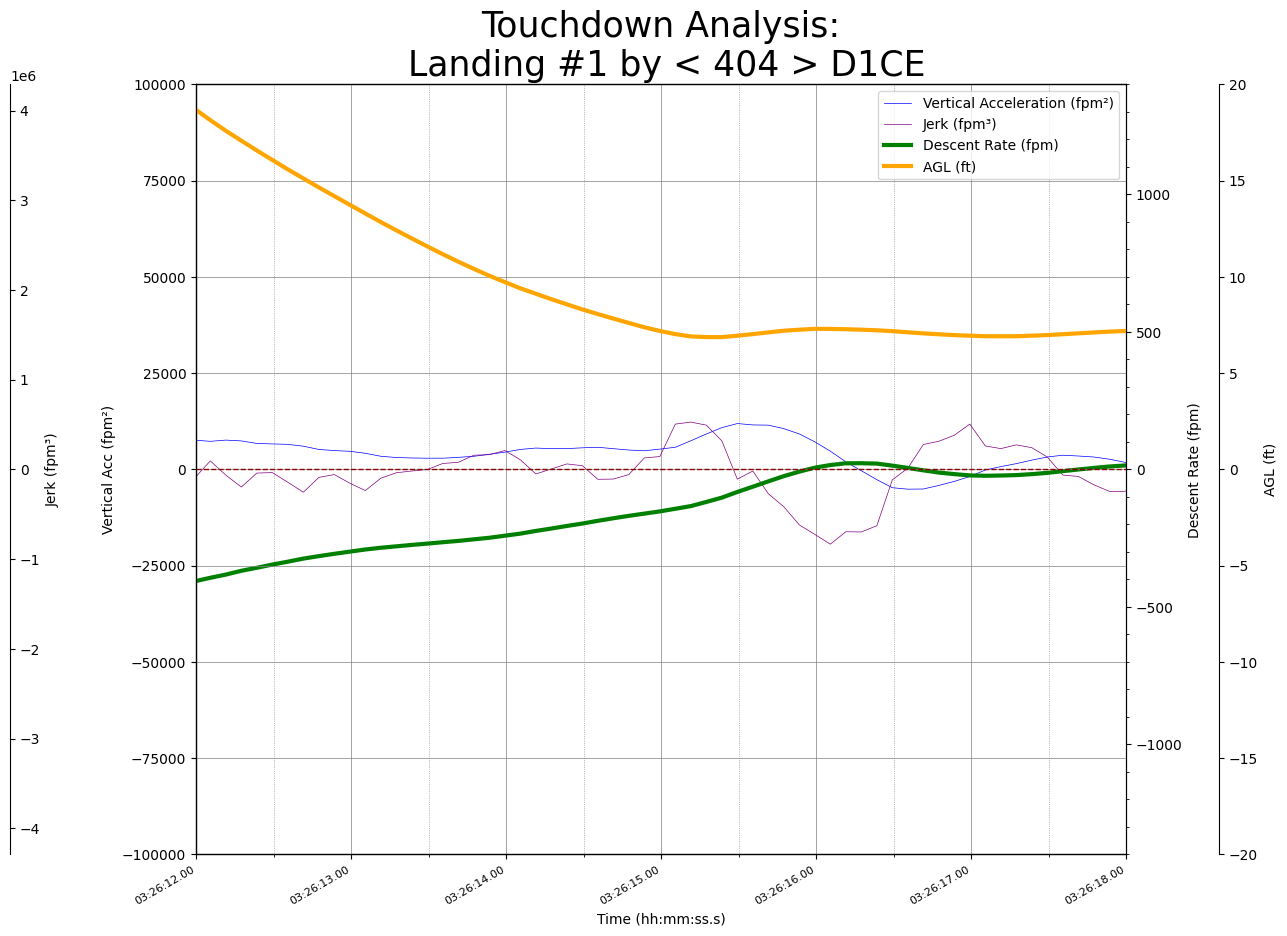

In [85]:
pilot_name = '< 404 > D1CE'
sortie_num = 1

df_plot = df_sub[df_sub['Pilot'] == pilot_name]
touch_moment = 80573.894112 # df_result[(df_result['Pilot'] == pilot_name) & (df_result['sortie_num'] == sortie_num)] ['td_timestamp_seconds'].values

time_window = (touch_moment-10, touch_moment+10)

#################### Vertical Impact plot ##################
fig, ax1= plt.subplots(figsize=(12, 10))
sns.lineplot(data=df_plot, x='timestamp_seconds', y='vert_Acc_fpm2', ax=ax1, 
             color='blue', linewidth=0.5, label='Vertical Acceleration (fpm²)')

# x-axis formatting

# Manual time_window
plt.xlim(dt.timedelta(hours=3, minutes=26, seconds= 12).total_seconds(), 
         dt.timedelta(hours=3, minutes=26, seconds= 18).total_seconds())

# time_window 2s around touchdown moment
# plt.xlim(time_window)

ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_seconds))

major_locator = ticker.MultipleLocator(1)   # Major ticks every ? seconds
minor_locator = ticker.MultipleLocator(0.5)  # Minor ticks every ? second
ax1.xaxis.set_major_locator(major_locator)
ax1.xaxis.set_minor_locator(minor_locator)

for label in ax1.get_xticklabels():
    label.set(rotation=30, horizontalalignment='right', fontsize= 8)

# y-axis formatting
plt.ylim(-1e5, 1e5)

#################### Jerk plot ##################
ax2 = ax1.twinx()
sns.lineplot(data=df_plot, x='timestamp_seconds', y='vert_Jerk_fpm3', ax=ax2, 
            color='purple', linewidth=0.5, label='Jerk (fpm³)')

ax2.spines["right"].set_position(("axes", -0.2))

ax2_lim = max(abs(ax2.get_ylim()[0]), abs(ax2.get_ylim()[1]))
ax2.set_ylim(-ax2_lim/4, ax2_lim/4)
# ax2.set_ylim(-2e7, 2e7)
# ax2.set_yticks(np.arange(-2e8, 2.5e8, 0.5e8))

offset_text = ax2.yaxis.get_offset_text()
offset_text.set_x(-0.20) # Adjust this value for perfect alignment
offset_text.set_horizontalalignment('left')

#################### Vertical Speed plot ##################
ax3 = ax1.twinx()
sns.lineplot(data=df_plot, x='timestamp_seconds', y='VS', ax=ax3, 
            color='green', linewidth=3, label='Descent Rate (fpm)')

ax3.set_ylim(-1400, 1400)
ax3.set_yticks(np.arange(-1400, 1500, 100), minor=True)

#################### AGL plot ##################
ax4 = ax1.twinx()
ax4.spines.right.set_position(("axes", 1.1))

sns.lineplot(data=df_plot, x='timestamp_seconds', y='AGL', ax=ax4, 
             color='orange', linewidth=3, label='AGL (ft)')

ax4.set_ylim(-20, 20)

ax4.axhline(y=0, color='darkred', linestyle='--', linewidth=1)

# GRIDLINES
ax1.grid(axis='x', which='major', linestyle='-', linewidth='0.5', color='gray')
ax1.grid(axis='x', which='minor', linestyle=':', linewidth='0.5', color='gray')             
ax4.grid(axis='y', which='major', linestyle='-', linewidth='0.5', color='gray') 
ax4.grid(axis='y', which='minor', linestyle=':', linewidth='0.5', color='gray') 

# TITLES
plt.title(f'Touchdown Analysis:\n Landing #{sortie_num} by {pilot_name}', fontsize=25)
ax1.set_xlabel('Time (hh:mm:ss.s)')
ax1.set_ylabel('Vertical Acc (fpm²)')
ax2.set_ylabel('Jerk (fpm³)')
ax3.set_ylabel('Descent Rate (fpm)')
ax4.set_ylabel('AGL (ft)')

# LEGENDS
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3 + lines4, labels + labels2 + labels3 + labels4, loc='upper right')

#### HERE IS THE IMPACT ####
plt.style.use('default')

plt.show()